In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp

ctl_color= "black"
exp_color="deepskyblue"


# the next two lines will expand the printed tables
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000

fig_folder= r"C:\Users\hta031\Github\FEDPROTEINPRO\plots\\"
#f.savefig(figfolder + "timeline pellets delievered+.pdf")


import matplotlib as mpl
mpl.rcParams['font.size'] = 16.0
# mpl.rcParams['axes.labelsize'] = 'medium'
# mpl.rcParams['ytick.labelsize'] = 'small'
# mpl.rcParams['savefig.transparent'] = True
# mpl.rc('lines', linewidth=0.75)
# mpl.rc('axes', linewidth=0.75, edgecolor="k", labelsize=9)


In [3]:
DATA_FOLDER = "..\\data"
df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_091022_00.CSV"))

def tweak_fed(df):
    
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
             .set_index("t")
             .query("Event == 'Pellet'")
              .loc["2022-09-12 08:00:00":] # cuts off training phase
             .loc[:,"ipi"] # could use .loc[:,["ipi", "col2", "col5" etc]] to get mutliple columns, e.g. animal name etc
           )
#tweak_fed(df) # could add animal name from metafile and diet and phase so these are returned in dataframe

In [4]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\FEDXC_METAFILE.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

ff_dict = {}
for row in rows:
    # file, mouse, diet, mode, sex,order,epoch = row
    fedfile, mouse, diet, mode, sex,order,epoch = row
    if (mode == "FF") and (diet in ["NR", "PR"]):
        key = "_".join([mouse, epoch])
        ff_dict[key] = {}
        ff_dict[key]["mouse"] = mouse
        ff_dict[key]["diet"] = diet
        ff_dict[key]["sex"] = sex
        ff_dict[key]["epoch"] = epoch
        ff_dict[key]["order"] = int(order)
        ff_dict[key]["pellets"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, fedfile)))  


File is excel file. Making csv metafile first


In [5]:
mice=[]
for key in ff_dict.keys():
    
    mouse= key.split("_")[0]
    if mouse not in mice:
        mice.append(mouse)

In [6]:
ff_dict_all_epochs={}
for mouse in mice:
    ff_dict_all_epochs[mouse]={}
    temp=[]
    for key, val in ff_dict.items():
        if mouse in key:
            temp.append(val["pellets"])
            ff_dict_all_epochs [mouse]["order"]= val["order"]
            
    ff_dict_all_epochs[mouse]["pellets"]=pd.concat(temp)       

Text(27, 26, ' Exp')

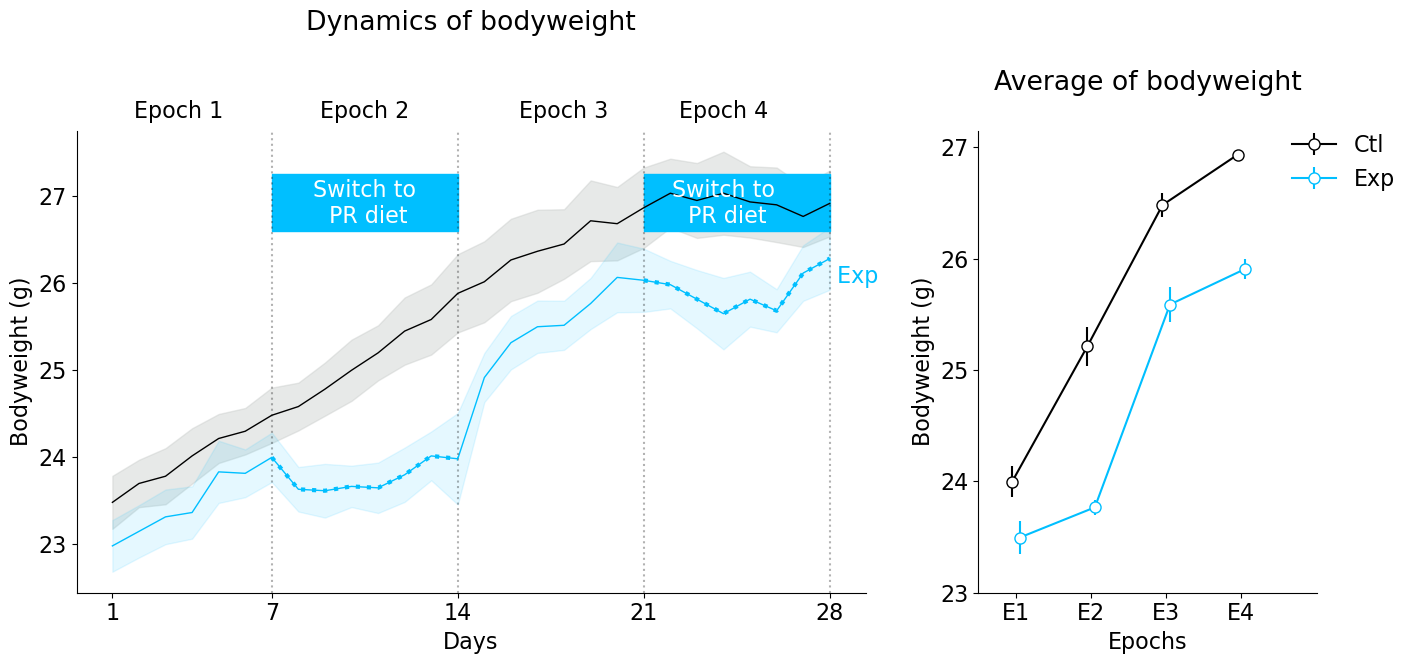

In [7]:
#gets bpdy weight data from the Metafile 
BW_DF=pd.read_excel(r"C:\Users\hta031\Github\FEDPROTEINPRO\FEDXC_METAFILE.xls" ,sheet_name="BODYWEIGHT" )

#divide the mice in Ctl and Exp groups then exclude training 
ctl=BW_DF.iloc[6:12]
exp=BW_DF.iloc[0:6] 
ctl_E1_4=ctl.iloc[: , 4:]
exp_E1_4= exp.iloc[: , 4:]


########################################################
f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                            gridspec_kw={"width_ratios":[0.7,0.3],
                                        "right":0.9, 
                                        "wspace":0.2,
                                        })
tp.shadedError(ax1,ctl_E1_4,linecolor=ctl_color)
tp.shadedError(ax1,exp_E1_4,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

#tp.shadedError(ax1,exp_pellets.T.iloc[: , 6:14],linecolor="orange", errorcolor= exp_color, alpha= 0, linewidth=1)




######################################################################################
ax1.set_ylabel("Bodyweight (g)")
ax1.set_xlabel("Days")

#drawing the vertical line for each epoch
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(20,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(27,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20,27],labels=["1","7","14","21","28"])
ax1.text(2.5,27.9,"Epoch 1", ha="center")
ax1.text(9.5,27.9,"Epoch 2", ha="center")
ax1.text(17,27.9,"Epoch 3", ha="center")
ax1.text(23,27.9,"Epoch 4", ha="center")




ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([27.25,26.6],[6], [13], color = "deepskyblue")
ax1.text(9.5,27.2,"Switch to\n PR diet", color="white",va="top", ha="center")

ax1.fill_betweenx([27.25,26.6],[20], [27], color = "deepskyblue")
ax1.text(23,27.2,"Switch to\n PR diet", color="white",va="top", ha="center")
# x=np.arange(6,14)
# y=exp_E1_3.iloc[:,7:13].mean(axis=0)
# ax1.plot(x, y,
#          linewidth=3,
#          color=exp_color,
#          linestyle=":")

# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,1),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_E1_4.iloc[:,0:7].mean(axis=0)
ctl_E2=ctl_E1_4.iloc[:,7:14].mean(axis=0)
ctl_E3=ctl_E1_4.iloc[:,14:21].mean(axis=0)
ctl_E4=ctl_E1_4.iloc[:,21:28].mean(axis=0)

exp_E1=exp_E1_4.iloc[:,0:7].mean(axis=0)
exp_E2=exp_E1_4.iloc[:,7:14].mean(axis=0)
exp_E3=exp_E1_4.iloc[:,14:21].mean(axis=0)
exp_E4=exp_E1_4.iloc[:,21:28].mean(axis=0)


#adds highlight on the line plot for Exp epoch 2
x=np.arange(6,14)
y=exp_E1_4.iloc[:,6:14].mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")


x2=np.arange(20,28)
y2=exp_E1_4.iloc[:,20:28].mean(axis=0)
ax1.plot(x2, y2,
         linewidth=3,
         color=exp_color,
         linestyle=":")
##################################################################################

spacing=0.05
ax2.errorbar([1-spacing,2-spacing,3-spacing, 4-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean(),ctl_E4.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem(), ctl_E4.sem()],
            marker="o",
            markerfacecolor="white",
             ms=8,
            linestyle="-",
            color=ctl_color,
             label="Ctl",
             
            )

ax2.errorbar([1+spacing,2+spacing,3+spacing, 4+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean(),exp_E4.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem(), exp_E4.sem()],
            marker="o",
             markerfacecolor="white",
             ms=8,
            linestyle="-",
            color=exp_color,
            label="Exp")

ax2.set_xticks([1,2,3,4],labels=["E1", "E2", "E3","E4"])
ax2.set_xlim([0.5,5])
ax2.set_yticks([23,24,25,26,27])
ax2.set_ylabel("Bodyweight (g)")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=(0.9,0.85), frameon=False)
ax2.set_xlabel("Epochs")
ax1.set_title("Dynamics of bodyweight",  y= 1.2)
ax2.set_title("Average of bodyweight",  y= 1.07)

# f.subplots_adjust(wspace=0.4)


# ax1.annotate(" Ctl",[21,26.8])
ax1.annotate(" Exp",[27,26], color= exp_color)

#f.savefig(fig_folder + "bodyweight_trend.pdf")

In [8]:
BW_DF

,mouseid,day0,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30
0,FEDXC01,23.6,23.4,22.6,22.9,22.8,23.0,23.3,23.6,23.6,24.0,23.8,23.3,23.2,23.2,23.3,23.3,24.0,24.5,25.1,25.1,25.3,25.3,25.7,26.1,26.1,25.1,25.2,25.7,25.5,25.7,25.4
1,FEDXC02,22.6,23.5,23.0,23.1,23.5,23.3,23.5,24.0,23.9,24.1,24.0,24.2,24.0,24.0,24.3,24.5,24.7,25.7,25.8,26.0,26.0,26.3,26.9,26.5,26.3,26.0,26.0,26.1,26.5,26.8,26.7
2,FEDXC03,22.1,22.2,21.9,21.8,22.2,22.8,22.6,22.6,22.9,23.0,22.6,22.4,23.1,22.9,22.7,23.4,21.6,24.2,24.5,24.8,24.8,25.0,24.9,24.5,24.9,24.8,24.3,24.8,24.7,24.8,25.3
3,FEDXC04,23.6,23.7,24.1,24.1,24.4,24.7,24.6,25.4,24.8,25.2,24.6,24.8,24.8,25.0,25.1,25.2,25.9,26.0,26.7,26.9,26.8,27.1,27.8,27.4,27.1,27.3,27.5,27.2,25.8,27.0,27.7
4,FEDXC05,22.1,22.8,22.7,22.5,22.5,22.3,22.4,23.2,23.2,23.4,23.2,23.3,23.4,23.1,23.5,23.5,23.7,24.8,24.6,24.9,24.9,25.3,25.4,25.5,25.6,25.5,25.0,25.1,25.3,25.7,25.7
5,FEDXC06,23.6,23.9,23.3,23.5,23.5,23.8,23.8,24.2,24.5,24.3,23.6,23.7,23.5,23.7,23.9,24.2,24.0,24.3,25.2,25.3,25.3,25.6,25.7,26.2,25.9,26.2,25.9,26.0,26.3,26.7,26.9
6,FEDXC07,24.6,24.3,25.1,24.9,24.7,25.1,24.8,25.1,24.8,25.4,25.3,25.3,25.5,25.6,26.0,26.3,26.7,26.8,26.8,27.0,27.0,27.2,27.2,27.5,27.4,26.8,26.8,26.8,27.0,27.1,27.3
7,FEDXC08,23.1,23.1,23.0,22.7,22.9,22.9,23.2,23.5,23.6,23.7,23.9,23.9,23.9,24.2,24.5,24.1,24.4,24.5,24.7,24.8,25.1,25.0,25.2,25.5,25.9,25.7,26.0,26.0,25.8,25.9,26.1
8,FEDXC09,22.9,23.0,22.8,23.1,23.8,23.5,23.3,23.9,24.0,24.1,24.3,24.6,24.8,24.5,25.0,25.3,25.4,25.8,25.9,25.8,26.1,26.6,26.7,26.2,26.2,26.6,26.4,26.7,26.2,26.3,26.2
9,FEDXC10,23.1,23.5,23.9,23.7,23.9,23.7,24.4,24.6,24.6,24.5,24.6,25.3,25.5,25.9,26.2,26.5,26.9,27.1,27.5,27.5,26.5,27.6,26.6,27.1,27.4,27.6,27.7,27.5,27.4,27.6,27.3


In [16]:
exp_E1_4


,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30
0,22.9,22.8,23.0,23.3,23.6,23.6,24.0,23.8,23.3,23.2,23.2,23.3,23.3,24.0,24.5,25.1,25.1,25.3,25.3,25.7,26.1,26.1,25.1,25.2,25.7,25.5,25.7,25.4
1,23.1,23.5,23.3,23.5,24.0,23.9,24.1,24.0,24.2,24.0,24.0,24.3,24.5,24.7,25.7,25.8,26.0,26.0,26.3,26.9,26.5,26.3,26.0,26.0,26.1,26.5,26.8,26.7
2,21.8,22.2,22.8,22.6,22.6,22.9,23.0,22.6,22.4,23.1,22.9,22.7,23.4,21.6,24.2,24.5,24.8,24.8,25.0,24.9,24.5,24.9,24.8,24.3,24.8,24.7,24.8,25.3
3,24.1,24.4,24.7,24.6,25.4,24.8,25.2,24.6,24.8,24.8,25.0,25.1,25.2,25.9,26.0,26.7,26.9,26.8,27.1,27.8,27.4,27.1,27.3,27.5,27.2,25.8,27.0,27.7
4,22.5,22.5,22.3,22.4,23.2,23.2,23.4,23.2,23.3,23.4,23.1,23.5,23.5,23.7,24.8,24.6,24.9,24.9,25.3,25.4,25.5,25.6,25.5,25.0,25.1,25.3,25.7,25.7
5,23.5,23.5,23.8,23.8,24.2,24.5,24.3,23.6,23.7,23.5,23.7,23.9,24.2,24.0,24.3,25.2,25.3,25.3,25.6,25.7,26.2,25.9,26.2,25.9,26.0,26.3,26.7,26.9


In [9]:
exp_pellets

NameError: name 'exp_pellets' is not defined

In [11]:
transposed_exp=exp_pellets.transpose()
transposed_ctl=ctl_pellets.transpose()




# Remove the last column
transposed_exp= transposed_exp.iloc[:, :-1]
transposed_ctl=transposed_ctl.iloc[:,:-1]
# # Transpose it back if needed
# result_df = transposed_df.transpose()

# # Now 'result_df' contains the DataFrame with the last column removed
#transposed_ctl.to_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\results\ctl_trend.csv")
#transposed_exp.to_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\results\exp_trend.csv")

In [12]:
transposed_exp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
n_pellets,147,147,146,167,158,167,162,135,132,137,150,164,176,181,229,187,176,163,178,162,185,135,124,115,165,183,162,169
n_pellets,180,189,185,182,199,177,177,166,159,162,166,182,181,206,225,206,189,179,185,167,186,155,167,160,185,192,189,210
n_pellets,148,163,175,168,166,171,165,159,165,180,181,192,169,149,314,202,188,173,175,184,198,168,153,164,168,190,187,187
n_pellets,216,205,219,197,205,200,191,162,162,180,197,202,214,212,257,225,206,212,202,204,205,165,193,211,231,101,233,261
n_pellets,175,163,132,152,219,207,191,176,202,228,261,265,313,296,264,240,211,230,218,230,219,216,219,219,264,282,275,283
n_pellets,185,167,167,169,177,155,160,141,144,152,164,180,189,177,205,208,192,174,165,180,168,160,176,170,172,171,177,178


Text(27, 210, ' Exp')

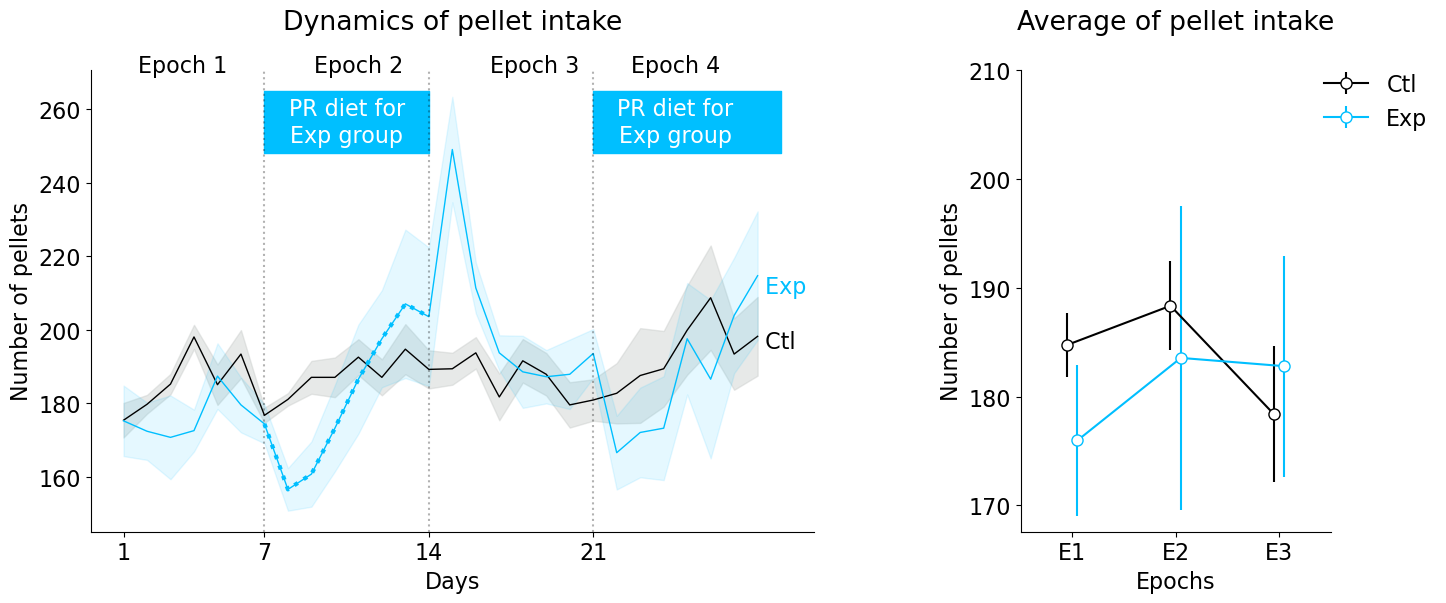

In [13]:
def pellets_by_day(df,maxdays=30):
    return (df
            .rename(index="n_pellets")
            .resample("d", offset = "7H")
            .count()
            .head(maxdays)#We need to add the final two rows instead of deleting last row 
            #.reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(pellets_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(pellets_by_day(val["pellets"]))  
        

def clean_df(lst):
    return (pd.concat(lst, axis= 1)
           .fillna(0)
            .reset_index()
            .iloc[:,1:]
           .head(29)) #21 days used because in epoch 4 we used expired pellets for ctl animals and data is excluded, more over the first 2 days of training not covered by the code

ctl_pellets= clean_df(ctl)
exp_pellets= clean_df(exp)

#######plotting the trend of pellet intake in the first 3 weeks in Ctl and Exp mice########################################


f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                            gridspec_kw={"width_ratios":[0.7,0.3],
                                         "right":0.9, 
                                        "wspace":0.4})
                            
tp.shadedError(ax1,transposed_ctl,linecolor=ctl_color)
tp.shadedError(ax1,transposed_exp,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)


######################################################################################
ax1.set_ylabel("Number of pellets")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(20,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,270,"Epoch 1", ha="center")
ax1.text(10,270,"Epoch 2", ha="center")
ax1.text(17.5,270,"Epoch 3", ha="center")
ax1.text(23.5,270,"Epoch 4", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([248,265],[6], [13], color = "deepskyblue")
ax1.text(9.5,263.2,"PR diet for\nExp group", color="white",va="top", ha="center")

ax1.fill_betweenx([248,265],[20], [28], color = "deepskyblue")
ax1.text(23.5,263.2,"PR diet for\nExp group", color="white",va="top", ha="center")
x=np.arange(6,14)
y=exp_pellets.iloc[6:14,:].T.mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")


# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,0.88),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_pellets.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_pellets.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_pellets.iloc[14:,:].mean(axis=0)
# ctl_E4=ctl_pellets.iloc[14:26,:].mean(axis=0)
exp_E1=exp_pellets.iloc[0:7,:].mean(axis=0)
exp_E2=exp_pellets.iloc[7:14,:].mean(axis=0)
exp_E3=exp_pellets.iloc[14:,:].mean(axis=0)
# exp_E4=exp_pellets.iloc[14:26,:].mean(axis=0)

##################################################################################

spacing=0.05

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
             marker="o",
             markerfacecolor="white",
             ms=8,
             linestyle="-",
             color=ctl_color,
             label="Ctl",
             
                )



ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
             marker="o",
             markerfacecolor="white",
             ms=8,
             linestyle="-",
             color=exp_color,
             label="Exp")

ax2.set_xticks([1,2,3],labels=["E1", "E2", "E3"])
ax2.set_xlim([0.5,3.5])
ax2.set_yticks([170,180,190,200,210])
ax2.set_ylabel("Number of pellets")
ax2.set_xlabel("Epochs")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=2)

ax1.set_title("Dynamics of pellet intake", y=1.07)
ax2.set_title("Average of pellet intake", y=1.07)
ax2.legend(loc=(0.95,0.85), frameon=False)
# f.subplots_adjust(wspace=0.4)

ax1.annotate(" Ctl",[27,195])
ax1.annotate(" Exp",[27,210], color= exp_color)


#f.savefig(fig_folder + "trend_pellet_delivery.tif")


In [16]:
transposed_exp_n_meals=exp_n_meals.transpose()
transposed_exp_meals=transposed_exp_n_meals.iloc[:,:-1]
transposed_exp_meals

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
n_meals,63.0,60.0,59.0,50.0,46.0,52.0,49.0,57.0,51.0,56.0,72.0,74.0,76.0,79.0,79.0,54.0,44.0,42.0,52.0,43.0,52.0,61.0,39.0,64.0,81.0,87.0,75.0,68.0
n_meals,94.0,95.0,79.0,84.0,84.0,85.0,80.0,104.0,94.0,99.0,100.0,86.0,88.0,84.0,90.0,87.0,76.0,68.0,84.0,70.0,82.0,80.0,91.0,108.0,107.0,121.0,91.0,94.0
n_meals,92.0,97.0,103.0,72.0,86.0,97.0,89.0,102.0,103.0,91.0,100.0,96.0,83.0,54.0,70.0,86.0,99.0,89.0,92.0,82.0,86.0,90.0,83.0,101.0,93.0,108.0,101.0,103.0
n_meals,139.0,119.0,117.0,110.0,92.0,96.0,101.0,93.0,92.0,89.0,91.0,88.0,92.0,86.0,118.0,99.0,84.0,83.0,92.0,83.0,103.0,92.0,102.0,92.0,100.0,56.0,98.0,120.0
n_meals,90.0,89.0,60.0,88.0,101.0,96.0,87.0,111.0,102.0,110.0,112.0,104.0,114.0,112.0,93.0,87.0,75.0,81.0,90.0,77.0,91.0,102.0,94.0,91.0,87.0,100.0,84.0,89.0
n_meals,87.0,77.0,61.0,61.0,56.0,60.0,66.0,70.0,74.0,86.0,81.0,67.0,71.0,87.0,79.0,68.0,67.0,56.0,73.0,65.0,69.0,85.0,80.0,75.0,80.0,85.0,66.0,73.0


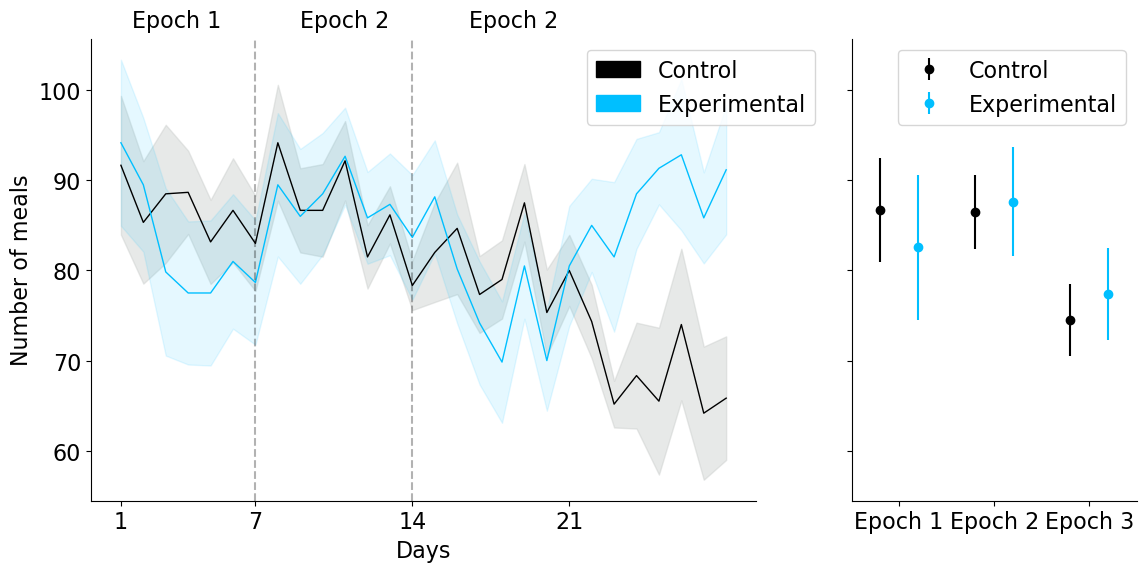

In [17]:
def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))

ctl_n_meals= clean_df(ctl)
exp_n_meals= clean_df(exp)


#################################################################


f, [ax1,ax2] = plt.subplots(figsize=(13.5,6), ncols=2,
                            sharey=True,
                           gridspec_kw={"width_ratios":[0.7,0.3]})
tp.shadedError(ax1,ctl_n_meals.T,linecolor=ctl_color)
tp.shadedError(ax1,transposed_exp_meals,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1)

######################################################################################
ax1.set_ylabel("Number of meals")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle="--", alpha= 0.3)
ax1.axvline(13,color="k",linestyle="--", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,107,"Epoch 1", ha="center")
ax1.text(10,107,"Epoch 2", ha="center")
ax1.text(17.5,107,"Epoch 2", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)



fed_cols = [ctl_color,exp_color]
Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
ax1.legend(handles=[Ctl_patch, Exp_patch],
             bbox_to_anchor=(0.67,0.88),
             bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_n_meals.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_n_meals.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_n_meals.iloc[14:,:].mean(axis=0)

exp_E1=exp_n_meals.iloc[0:7,:].mean(axis=0)
exp_E2=exp_n_meals.iloc[7:14,:].mean(axis=0)
exp_E3=exp_n_meals.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.2

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="",
            color=ctl_color,
             label="Control")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="",
            color=exp_color,
            label="Experimental")

ax2.set_xticks([1,2,3],labels=["Epoch 1", "Epoch 2", "Epoch 3"])
ax2.set_xlim([0.5,3.5])

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend()

#f.savefig(fig_folder + "meal_number.png")


In [20]:
exp_meal_size_transposed= exp_meal_size.transpose()
transposed_exp_meal_size=exp_meal_size_transposed.iloc[:,:-1]
transposed_exp_meal_size

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
mealsize,2.380952,2.616667,2.423729,3.320000,3.413043,3.134615,3.469388,2.368421,2.588235,2.428571,2.083333,2.243243,2.276316,2.316456,2.949367,3.462963,3.931818,3.928571,3.326923,3.906977,3.461538,2.245902,2.871795,1.937500,2.074074,2.068966,2.253333,2.367647
mealsize,2.000000,2.021053,2.329114,2.202381,2.273810,2.164706,2.225000,1.586538,1.702128,1.616162,1.680000,2.034884,2.125000,2.452381,2.533333,2.344828,2.500000,2.558824,2.154762,2.528571,2.195122,1.937500,1.824176,1.500000,1.757009,1.570248,2.087912,2.223404
mealsize,1.641304,1.752577,1.708738,2.180556,1.988372,1.773196,1.910112,1.529412,1.640777,1.846154,1.820000,1.989583,2.084337,2.759259,4.528571,2.267442,1.898990,1.943820,1.989130,2.170732,2.360465,1.788889,1.855422,1.643564,1.806452,1.777778,1.891089,1.796117
mealsize,1.625899,1.647059,1.957265,1.781818,2.206522,2.062500,1.910891,1.677419,1.804348,2.123596,2.186813,2.250000,2.260870,2.546512,2.144068,2.252525,2.535714,2.469880,2.206522,2.397590,2.067961,1.793478,1.931373,2.293478,2.280000,1.571429,2.510204,2.141667
mealsize,2.000000,1.853933,2.083333,1.875000,2.108911,2.135417,2.275862,1.612613,1.960784,2.100000,2.330357,2.480769,2.850877,2.660714,2.645161,2.896552,2.826667,2.691358,2.577778,2.896104,2.450549,2.147059,2.372340,2.428571,2.908046,2.820000,3.345238,3.168539
mealsize,2.183908,2.168831,2.655738,2.934426,3.071429,2.616667,2.484848,1.957143,1.959459,1.779070,2.061728,2.626866,2.633803,2.091954,2.594937,3.073529,2.791045,3.107143,2.342466,2.661538,2.434783,1.976471,2.187500,2.226667,2.137500,2.035294,2.636364,2.520548


Text(20, 2.5, ' Exp')

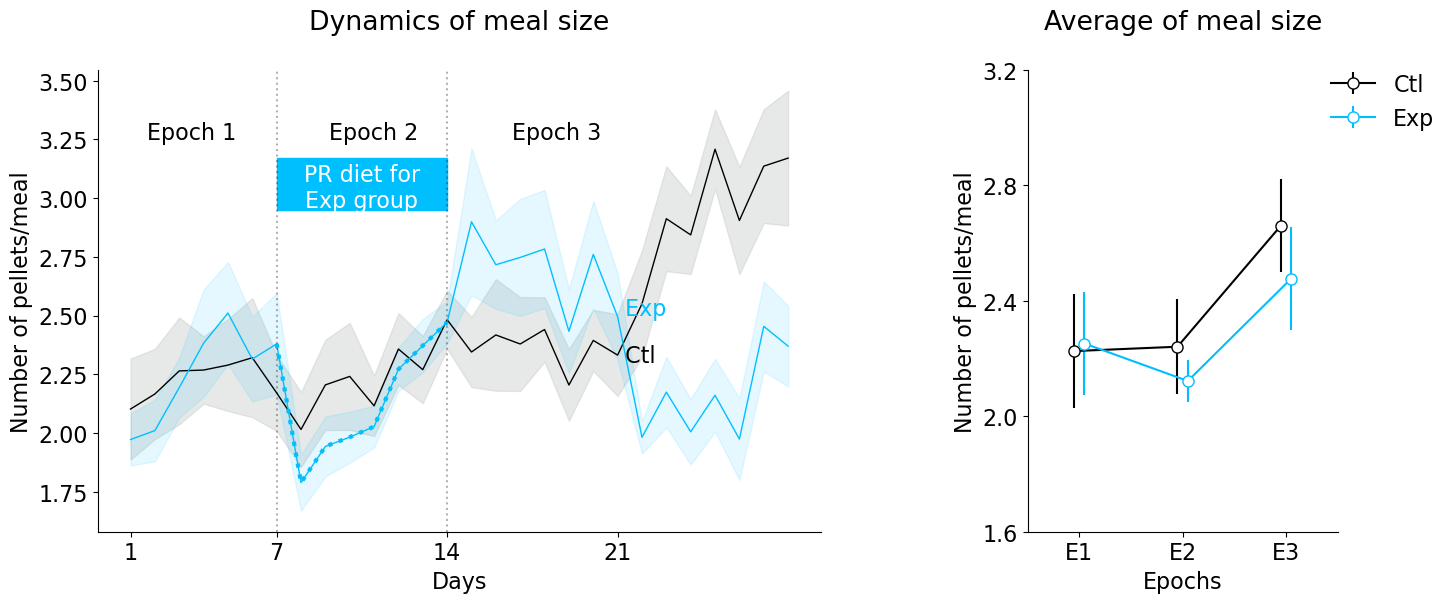

In [21]:
def mealsize_by_day(df):
    return (df
            .rename(index="mealsize")
            .resample("d", offset = "8H")
            .apply(lambda df_: df_.count()/sum(df_ > 60))
            
#              .reset_index()
            
           )
#mealsize_by_day (ff_dict_all_epochs["FEDXC01"]["pellets"])


ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(mealsize_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(mealsize_by_day(val["pellets"]))

ctl_meal_size= clean_df(ctl)

exp_meal_size= clean_df(exp)


#################################################################


f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                           gridspec_kw={"width_ratios":[0.7,0.3],
                                        "right":0.9, 
                                        "wspace":0.4})
tp.shadedError(ax1,ctl_meal_size.T,linecolor=ctl_color)
tp.shadedError(ax1,transposed_exp_meal_size,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

######################################################################################
ax1.set_ylabel("Number of pellets/meal")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,3.25,"Epoch 1", ha="center")
ax1.text(10,3.25,"Epoch 2", ha="center")
ax1.text(17.5,3.25,"Epoch 3", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([2.95,3.17],[6], [13], color = "deepskyblue")
ax1.text(9.5,3.15,"PR diet for\nExp group", color="white",va="top", ha="center")
x=np.arange(6,14)
y=exp_meal_size.iloc[6:14,:].T.mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")

# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,0.88),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_meal_size.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_meal_size.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_meal_size.iloc[14:,:].mean(axis=0)

exp_E1=exp_meal_size.iloc[0:7,:].mean(axis=0)
exp_E2=exp_meal_size.iloc[7:14,:].mean(axis=0)
exp_E3=exp_meal_size.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.05

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="-",
            markerfacecolor= "white",
            ms=8,
            color=ctl_color,
             label="Ctl")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="-",
             markerfacecolor="white",
             ms=8,
            color=exp_color,
            label="Exp")

ax2.set_xticks([1,2,3],labels=["E1", "E2", "E3"])
ax2.set_xlim([0.5,3.5])
ax2.set_yticks([1.6,2,2.4,2.8,3.2])
ax2.set_ylabel("Number of pellets/meal")
ax2.set_xlabel("Epochs")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=(0.95,0.85), frameon=False)

ax1.set_title("Dynamics of meal size", y=1.07)
ax2.set_title("Average of meal size",y=1.07)

# f.subplots_adjust(wspace=0.4)

ax1.annotate(" Ctl",[20,2.3])
ax1.annotate(" Exp",[20,2.5], color= exp_color)

#f.savefig(fig_folder + "mealsize.pdf")



In [32]:
exp_meal_size_transposed= exp_meal_size.transpose()
transposed_exp_meal_size=exp_meal_size_transposed.iloc[:,:-1]
transposed_exp_meal_size.round(2)

transposed_exp_meal_size.round(2).to_csv(r"C:\Users\hta031\Github\FEDPROTEINPRO\results\exp_mealsize.csv")

In [35]:
ctl_meal_size_transposed= ctl_meal_size.transpose()
transposed_ctl_meal_size=ctl_meal_size_transposed.iloc[:,:]
transposed_ctl_meal_size.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
mealsize,2.28,2.44,2.06,2.11,1.89,1.84,1.77,1.68,1.72,1.66,1.84,1.83,1.99,2.16,2.07,1.67,1.76,1.99,1.86,2.20,1.93,2.01,2.42,2.52,3.22,2.52,2.75,2.48
mealsize,1.50,1.78,1.59,1.88,2.12,2.15,2.02,1.70,1.97,1.99,2.10,2.20,1.96,2.29,2.38,2.13,2.72,2.28,1.87,2.16,2.17,2.02,2.36,2.39,3.52,3.31,3.40,3.87
mealsize,2.01,2.17,2.53,2.25,1.91,1.87,1.85,1.67,1.98,2.12,1.93,2.29,2.12,2.38,1.89,2.14,2.09,2.22,1.92,2.04,1.89,2.75,2.66,2.57,2.32,1.88,2.13,2.06
mealsize,3.13,3.05,3.35,2.97,3.31,3.62,2.93,2.76,3.20,3.43,2.69,3.00,2.77,2.90,3.05,3.15,2.50,2.81,2.90,2.87,3.08,2.86,2.99,2.89,3.43,3.00,3.28,3.16
mealsize,2.04,1.88,2.02,2.37,2.22,1.97,2.02,2.10,2.14,2.16,1.79,2.18,2.02,2.27,2.24,2.15,1.99,2.40,2.28,2.29,2.24,2.12,3.07,3.13,3.53,3.16,4.06,3.97
mealsize,1.66,1.67,2.03,2.03,2.27,2.47,2.42,2.17,2.22,2.09,2.34,2.65,2.75,2.90,2.44,3.26,3.21,2.95,2.39,2.79,2.69,3.54,3.98,3.57,3.24,3.57,3.20,3.48


In [34]:
transposed_exp_meal_size.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
mealsize,2.38,2.62,2.42,3.32,3.41,3.13,3.47,2.37,2.59,2.43,2.08,2.24,2.28,2.32,2.95,3.46,3.93,3.93,3.33,3.91,3.46,2.25,2.87,1.94,2.07,2.07,2.25,2.37
mealsize,2.00,2.02,2.33,2.20,2.27,2.16,2.22,1.59,1.70,1.62,1.68,2.03,2.12,2.45,2.53,2.34,2.50,2.56,2.15,2.53,2.20,1.94,1.82,1.50,1.76,1.57,2.09,2.22
mealsize,1.64,1.75,1.71,2.18,1.99,1.77,1.91,1.53,1.64,1.85,1.82,1.99,2.08,2.76,4.53,2.27,1.90,1.94,1.99,2.17,2.36,1.79,1.86,1.64,1.81,1.78,1.89,1.80
mealsize,1.63,1.65,1.96,1.78,2.21,2.06,1.91,1.68,1.80,2.12,2.19,2.25,2.26,2.55,2.14,2.25,2.54,2.47,2.21,2.40,2.07,1.79,1.93,2.29,2.28,1.57,2.51,2.14
mealsize,2.00,1.85,2.08,1.88,2.11,2.14,2.28,1.61,1.96,2.10,2.33,2.48,2.85,2.66,2.65,2.90,2.83,2.69,2.58,2.90,2.45,2.15,2.37,2.43,2.91,2.82,3.35,3.17
mealsize,2.18,2.17,2.66,2.93,3.07,2.62,2.48,1.96,1.96,1.78,2.06,2.63,2.63,2.09,2.59,3.07,2.79,3.11,2.34,2.66,2.43,1.98,2.19,2.23,2.14,2.04,2.64,2.52


In [22]:
exp_t_freq.transpose().iloc[:,:-1].round()

NameError: name 'exp_t_freq' is not defined

Text(20, 3.4, ' Exp')

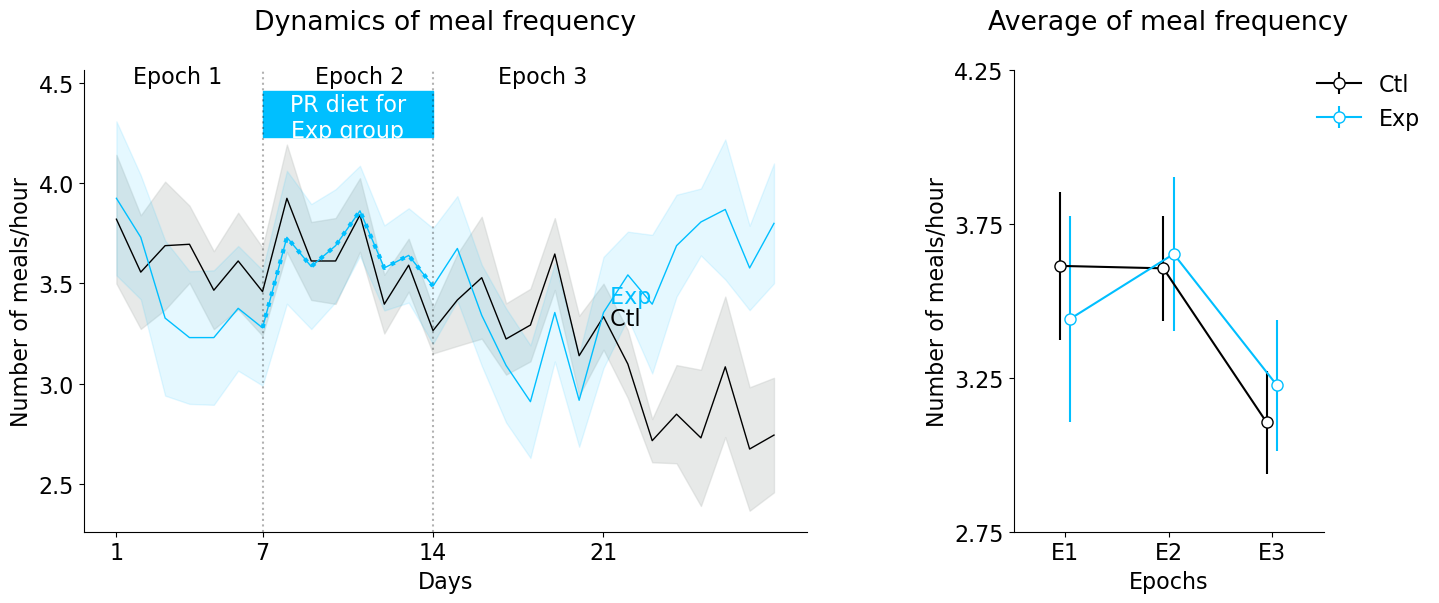

In [47]:
#######Calculates meal frequency 



def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))
##################################################################################
ctl_freq=[]
for x in ctl:
    ctl_freq.append(x/24) 
    # print(ctl_freq)
    
exp_freq=[]
for x in exp:
    exp_freq.append(x/24)
    # print(exp_freq)
    
#####################################################################################

ctl_t_freq= clean_df(ctl_freq)
exp_t_freq= clean_df(exp_freq)


###################################################################################


f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                           gridspec_kw={"width_ratios":[0.7,0.3],
                                        "right":0.9, 
                                        "wspace":0.4})
tp.shadedError(ax1,ctl_t_freq.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_t_freq.transpose().iloc[:,:-1],linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

######################################################################################
ax1.set_ylabel("Number of meals/hour")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle=":", alpha= 0.3)
ax1.axvline(13,color="k",linestyle=":", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,4.50,"Epoch 1", ha="center")
ax1.text(10,4.50,"Epoch 2", ha="center")
ax1.text(17.5,4.50,"Epoch 3", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


#adding a highlight bar at the top of EPOCH 2
ax1.fill_betweenx([4.23,4.46],[6], [13], color = "deepskyblue")
ax1.text(9.5,4.45,"PR diet for\nExp group", color="white",va="top", ha="center")
x=np.arange(6,14)
y=exp_t_freq.iloc[6:14,:].T.mean(axis=0)
ax1.plot(x, y,
         linewidth=3,
         color=exp_color,
         linestyle=":")

# fed_cols = [ctl_color,exp_color]
# Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
# Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
# ax1.legend(handles=[Ctl_patch, Exp_patch],
#              bbox_to_anchor=(0.67,0.88),
#              bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_t_freq.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_t_freq.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_t_freq.iloc[14:,:].mean(axis=0)

exp_E1=exp_t_freq.iloc[0:7,:].mean(axis=0)
exp_E2=exp_t_freq.iloc[7:14,:].mean(axis=0)
exp_E3=exp_t_freq.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.05

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="-",
            markerfacecolor= "white",
            ms=8,
            color=ctl_color,
             label="Ctl")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="-",
             markerfacecolor="white",
             ms=8,
            color=exp_color,
            label="Exp")

ax2.set_xticks([1,2,3],labels=["E1", "E2", "E3"])
ax2.set_xlim([0.5,3.5])
ax2.set_yticks([2.75,3.25,3.75,4.25])
ax2.set_ylabel("Number of meals/hour")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=(0.95,0.85), frameon=False)
ax2.set_xlabel("Epochs")
ax1.set_title("Dynamics of meal frequency", y=1.07)
ax2.set_title("Average of meal frequency",y=1.07)

# f.subplots_adjust(wspace=0.4)

ax1.annotate(" Ctl",[20,3.29])
ax1.annotate(" Exp",[20,3.40], color= exp_color)

#f.savefig(fig_folder + "meal_freq.pdf")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


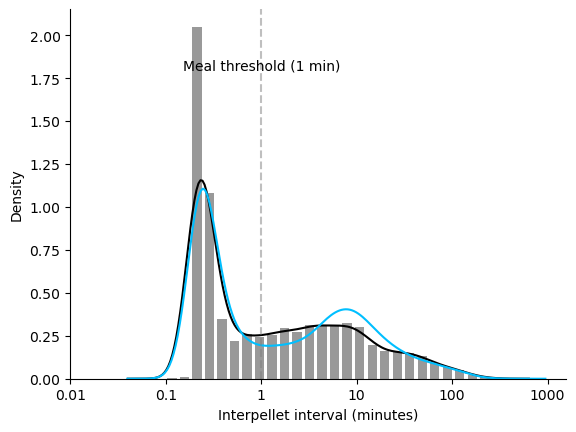

In [13]:

all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna().clip(1))
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E2":
        if data ["diet"] == "NR":
            NR_IPIS.append(data["pellets"].dropna().clip(1))
        elif  data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = True, hist_kws={"rwidth":0.75} )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])



# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

#sns.set_style("white")
#sns.set(rc={"figure.figsize":(13, 6)}) 




ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig(fig_folder + "KDE.png")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


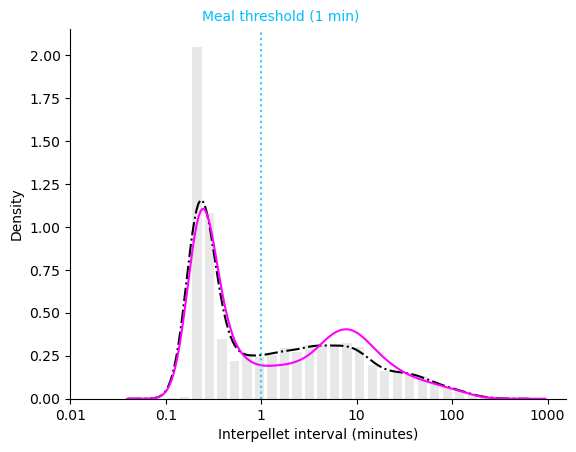

In [8]:
# Control Epoch 2 NR vs Experimental Epoch 2 NR
all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E2":
        if data ["diet"] == "NR":
            NR_IPIS.append(data["pellets"].dropna().clip(1))
        elif  data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = True, 
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'-.'})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])



# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle=":", color="deepskyblue", alpha=0.8)
ax.text(0.2,2.2, "Meal threshold (1 min)", ha="center", color="deepskyblue")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)



#f.savefig(fig_folder + "KDE_V2.png")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


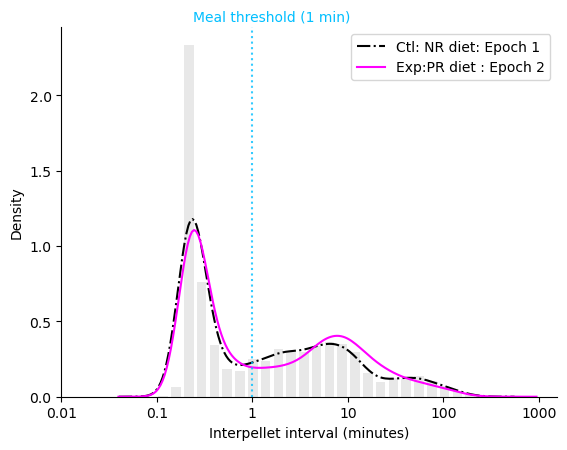

In [10]:
#Control Epoch 1 NR vs Experimental Epoch 2 PR
all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E1":
        if data ["order"] == 1:
            if data ["diet"] == "NR":
                NR_IPIS.append(data["pellets"].dropna().clip(1))
    if data ["epoch"] == "E2":
        if data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    
    
       
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = True,
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'-.' ,"shade":False, "label" : "Ctl: NR diet: Epoch 1"})

ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data2 = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True , label ="Exp:PR diet : Epoch 2")
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])



# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle=":", color="deepskyblue", alpha=0.8)
ax.text(0.2,2.5, "Meal threshold (1 min)", ha="center", color="deepskyblue")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend()

#f.savefig(fig_folder + "KDE_V2.png")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


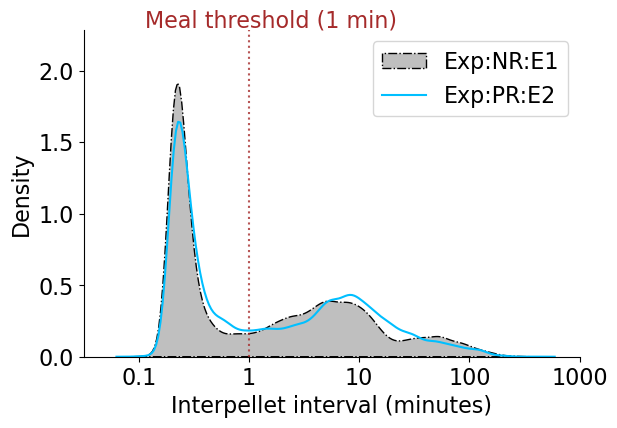

In [34]:
################## Experimental group NR diet Epoch 1 vs Epxerimental group PR diet Epoch 2
all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E1":
        if data ["order"] == 2:
            if data ["diet"] == "NR":
                NR_IPIS.append(data["pellets"].dropna().clip(1))
    if data ["epoch"] == "E2":
        if data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    
    
       
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots(gridspec_kw={"bottom":0.2})


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = False, 
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'-.', "shade":True,"bw_adjust":0.5}, label ="Exp:NR:E1")
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

data = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True, label = "Exp:PR:E2" ,
                   kde_kws={"bw_adjust":0.5})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])
ax.set_yticks([0,0.5,1,1.5,2])
ax.set_xlim([-1.5,3])
ax.set_ylim(0.0, 2.2809548671887865)

# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle=":", color="brown", alpha=0.8)
ax.text(0.2,2.3, "Meal threshold (1 min)", ha="center", color="brown")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()

#sns.set(rc={'figure.figsize':(3,6.5)})


f.savefig(fig_folder + "KDE_Hist_E1EXP_VS_E2EXP.pdf")


In [27]:
ax.get_ylim()

(0.0, 2.00926054909078)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


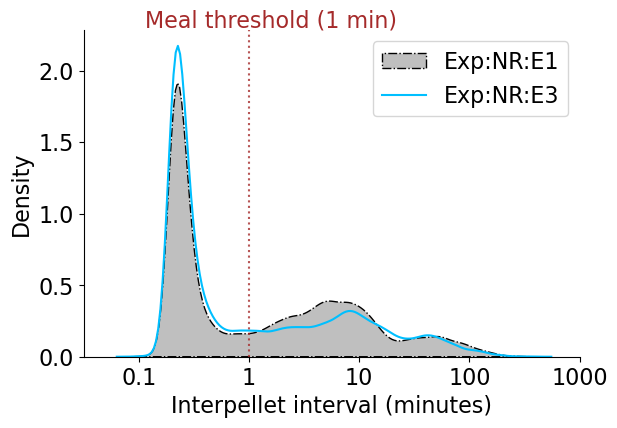

In [28]:
#Experimental group Epoch 1 NR vs Experimental group Epoch 3 NR
all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E1":
        if data ["order"] == 2:
            if data ["diet"] == "NR":
                NR_IPIS.append(data["pellets"].dropna().clip(1))
    if data ["epoch"] == "E3":
        if data["order"] == 2:
            if data ["diet"] == "NR":
                PR_IPIS.append(data["pellets"].dropna().clip(1))
    
    
       
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots(gridspec_kw={"bottom":0.2})


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = False, label = "Exp:NR:E1",
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'-.', "shade":True,"bw_adjust": 0.5})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data2 = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True, label= "Exp:NR:E3",
                    kde_kws={"bw_adjust": 0.5})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])
ax.set_xlim([-1.5,3])


# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle=":", color="brown", alpha=0.8)
ax.text(0.2,2.3, "Meal threshold (1 min)", ha="center", color="brown")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()

#f.savefig(fig_folder + "KDE_E1EXP_VS_E3EXP.pdf")


In [29]:
ax.get_ylim()

(0.0, 2.2809548671887865)